In [1]:
from layer import Dense, Dropout, Conv2d, Flatten, MaxPool2d
from activation import LeakyReLU
from solver import SGD
from loss import CrossEntropyLoss
from data import Dataset
from network import Network
from utils import *

import numpy as np
import matplotlib.pyplot as plt
import joblib

from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

np.random.seed(42)

# MNIST

### Load MNIST

In [2]:
# load mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### X transform

In [3]:
# data preproccess
X_train = X_train.astype('float32')   
X_test = X_test.astype('float32')

# get values from 0 to 1
X_train /= 255                        
X_test /= 255

# reshape so that it has 1 channel
X_train = X_train.reshape(60000, 1, 28, 28)
X_test = X_test.reshape(10000, 1, 28, 28)

In [4]:
# create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

### Class balance

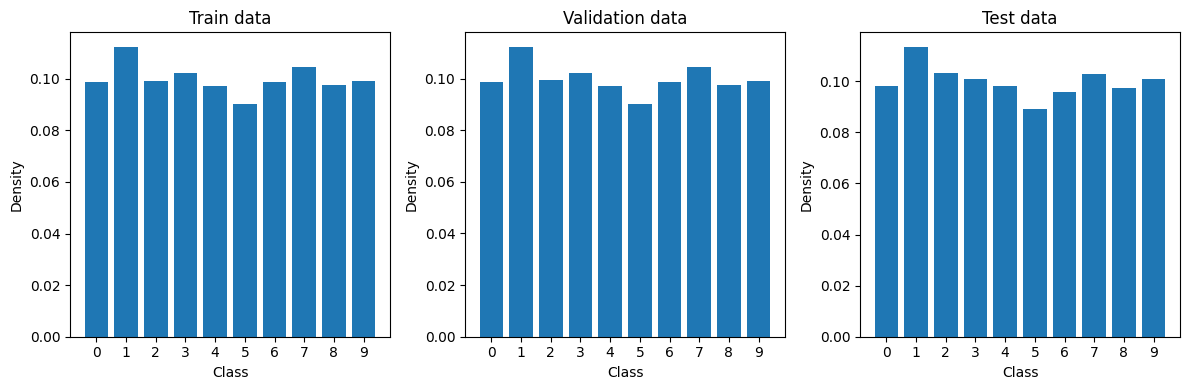

In [5]:
mnist_labels = range(0,10)

plot_class_balance([y_train, y_val, y_test], mnist_labels)

### Y transform

In [6]:
no_classes = 10
y_train = np.eye(no_classes)[y_train]
y_val = np.eye(no_classes)[y_val]
y_test = np.eye(no_classes)[y_test]

In [7]:
train_data = Dataset(X_train, y_train)
val_data = Dataset(X_val, y_val)
test_data = Dataset(X_test, y_test)

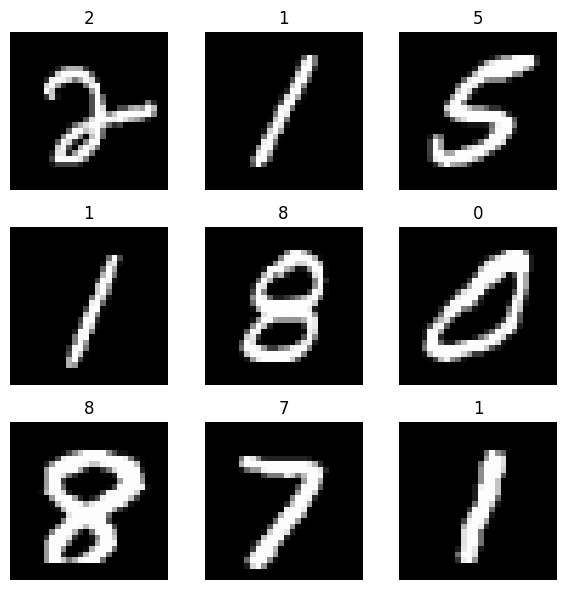

In [8]:
show_grid(X_train[:9], y_train[:9], class_names=mnist_labels)

### Dense NN

In [9]:
solver = SGD(lr=0.1)
loss = CrossEntropyLoss()

early_stopping={
    'patience': 5,
    'min_delta': 0,
    'restore_best_parameters': True
}

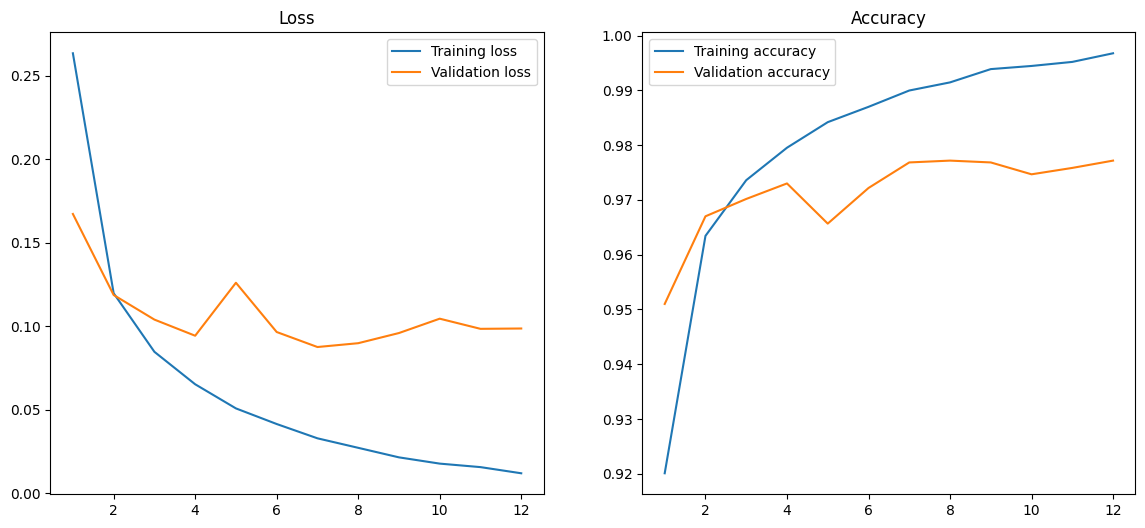

In [10]:
mnist_nn = Network([
    Flatten(),                    # 28*28 -> 784
    
    Dense(128),
    LeakyReLU(0.1),

    Dense(128),
    LeakyReLU(0.1),

    Dense(10),
])

mnist_nn.compile(loss, solver)

try:
    mnist_nn = joblib.load('models//mnist_nn_1.joblib')
except:
    history = mnist_nn.train(dataset=train_data, epochs=20, val_dataset=val_data, early_stopping=early_stopping)
    # save the model
    joblib.dump(mnist_nn, 'models//mnist_nn_1.joblib')

plot_hist(mnist_nn.history)

early stopping triggered at epoch 12, params reverted to epoch 7

In [11]:
y_pred = mnist_nn.predict(X_test)
accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

0.9779

              precision    recall  f1-score   support

           0     0.9807    0.9847    0.9827       980
           1     0.9878    0.9956    0.9917      1135
           2     0.9787    0.9777    0.9782      1032
           3     0.9848    0.9634    0.9740      1010
           4     0.9877    0.9837    0.9857       982
           5     0.9648    0.9821    0.9733       892
           6     0.9742    0.9854    0.9798       958
           7     0.9879    0.9553    0.9713      1028
           8     0.9813    0.9692    0.9752       974
           9     0.9501    0.9812    0.9654      1009

    accuracy                         0.9779     10000
   macro avg     0.9778    0.9778    0.9777     10000
weighted avg     0.9781    0.9779    0.9779     10000



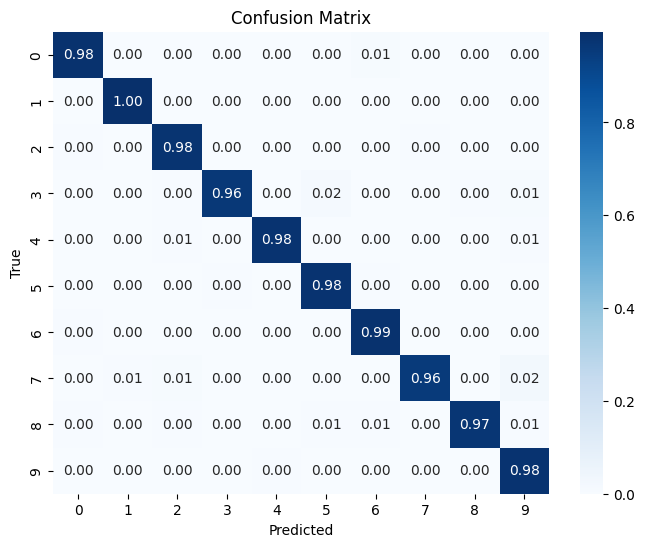

In [12]:
evaluate_classification(y_test, y_pred)

### CNN

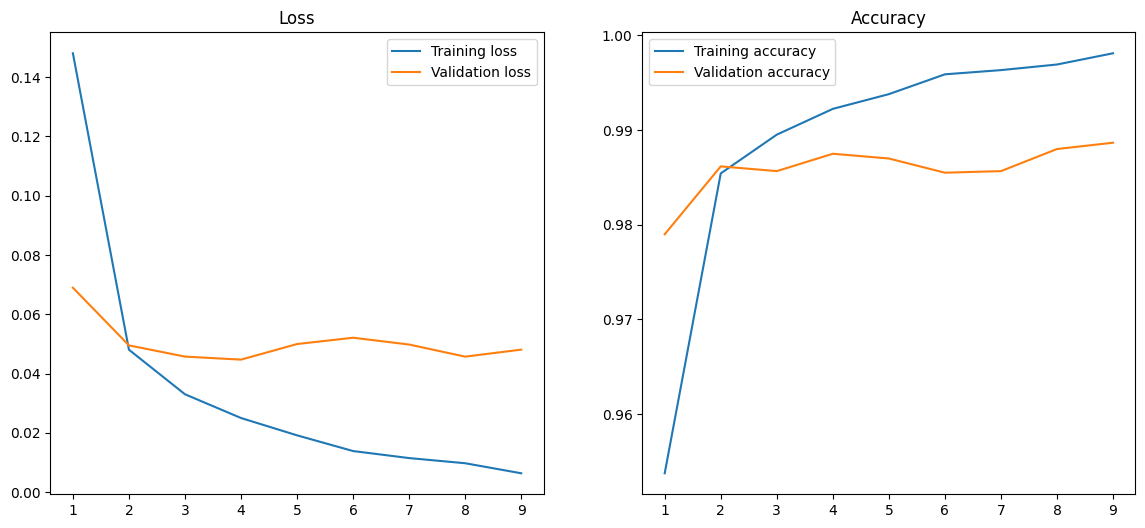


Acc: 0.9896

              precision    recall  f1-score   support

           0     0.9939    0.9949    0.9944       980
           1     0.9956    0.9956    0.9956      1135
           2     0.9941    0.9845    0.9893      1032
           3     0.9805    0.9950    0.9877      1010
           4     0.9939    0.9908    0.9924       982
           5     0.9833    0.9922    0.9877       892
           6     0.9958    0.9823    0.9890       958
           7     0.9836    0.9903    0.9869      1028
           8     0.9857    0.9918    0.9887       974
           9     0.9890    0.9782    0.9836      1009

    accuracy                         0.9896     10000
   macro avg     0.9895    0.9896    0.9895     10000
weighted avg     0.9896    0.9896    0.9896     10000



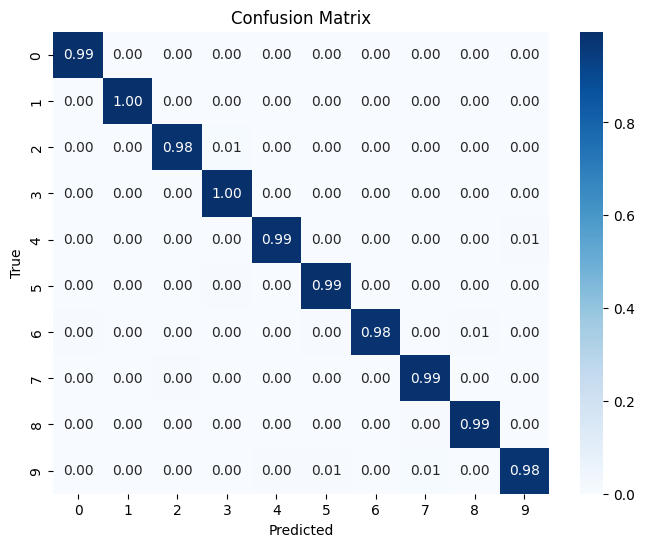

In [13]:
mnist_cnn = Network([
    Conv2d(1, 16, 3, padding=1),  # 16 x 28 x 28
    LeakyReLU(0.1), 
    MaxPool2d(),                  # 16 x 14 x 14

    Conv2d(16, 32, 3, padding=1), # 32 x 14 x 14
    LeakyReLU(0.1), 
    MaxPool2d(),                  # 32 x 7 x 7

    Flatten(),                    # 32*7*7 -> 1568
    
    Dense(128),
    LeakyReLU(0.1),

    Dense(10),
])

mnist_cnn.compile(loss=loss, solver=solver)

try:
    mnist_cnn = joblib.load('models//mnist_cnn_1.joblib')
except:
    history = mnist_cnn.train(dataset=train_data, epochs=10, val_dataset=val_data, early_stopping=early_stopping)
    # save the model
    joblib.dump(mnist_cnn, 'models//mnist_cnn_1.joblib')

plot_hist(mnist_cnn.history)
# early stopping triggered at epoch 9, params reverted to epoch 4
y_pred = mnist_cnn.predict(X_test)

print("\nAcc:", accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print()

evaluate_classification(y_test, y_pred)

# Transform MNIST

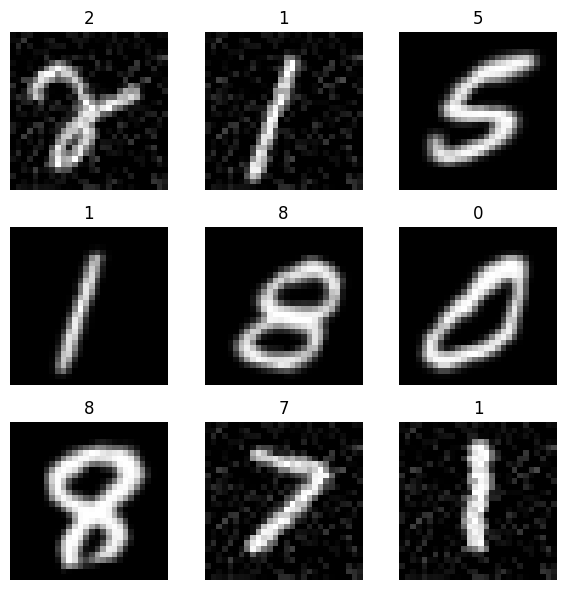

In [14]:
show_grid(transform_mnist_dataset(X_train[:9]), y_train[:9], class_names=mnist_labels)

In [15]:
train_data_trans = Dataset(X_train, y_train, transform=transform_mnist_dataset)

### Dense NN

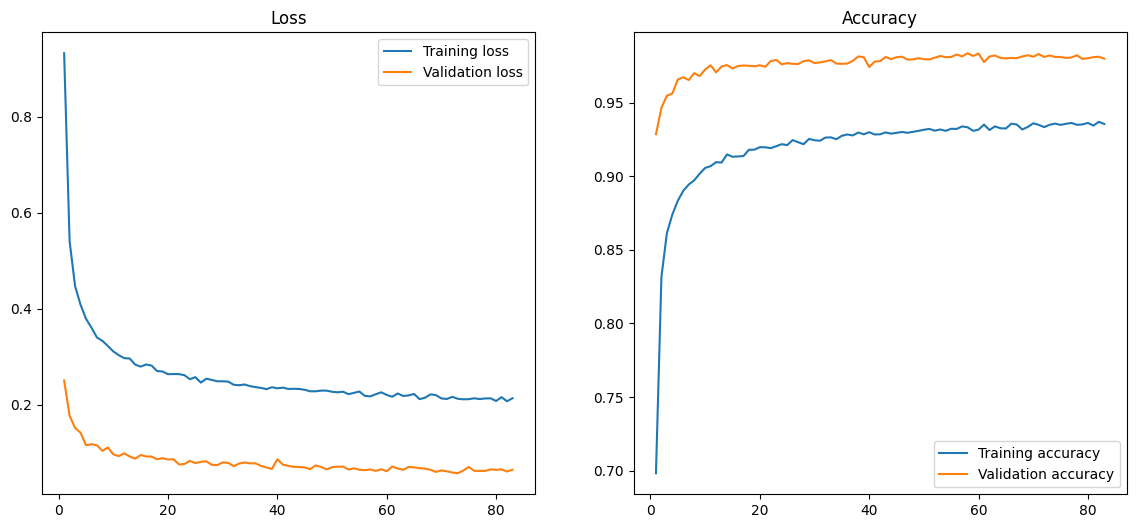

{'epoch_stopped': 83, 'epoch_params': 73}

Acc: 0.9838

              precision    recall  f1-score   support

           0     0.9898    0.9898    0.9898       980
           1     0.9921    0.9921    0.9921      1135
           2     0.9761    0.9903    0.9832      1032
           3     0.9870    0.9782    0.9826      1010
           4     0.9877    0.9827    0.9852       982
           5     0.9788    0.9854    0.9821       892
           6     0.9874    0.9854    0.9864       958
           7     0.9702    0.9835    0.9768      1028
           8     0.9906    0.9723    0.9813       974
           9     0.9782    0.9772    0.9777      1009

    accuracy                         0.9838     10000
   macro avg     0.9838    0.9837    0.9837     10000
weighted avg     0.9839    0.9838    0.9838     10000



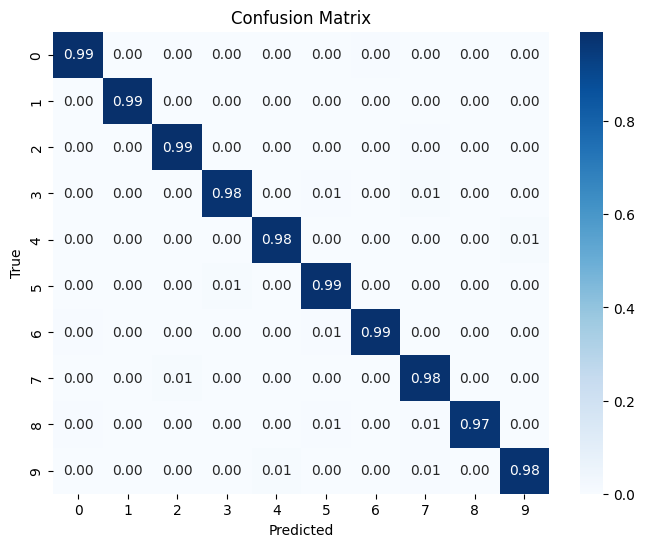

In [16]:
mnist_nn_2 = Network([
    Flatten(),                    # 28*28 -> 784
    
    Dense(128),
    LeakyReLU(0.1),
    Dropout(0.3),

    Dense(128),
    LeakyReLU(0.1),
    Dropout(0.3),

    Dense(10),
])

mnist_nn_2.compile(loss, solver)

early_stopping['patience'] = 10

try:
    mnist_nn_2 = joblib.load('models//mnist_nn_2.joblib')
except:
    history = mnist_nn_2.train(dataset=train_data_trans, epochs=100, val_dataset=val_data, early_stopping=early_stopping)
    # save the model
    joblib.dump(mnist_nn_2, 'models//mnist_nn_2.joblib')

plot_hist(mnist_nn_2.history)


try:
    print(mnist_nn_2.early_stopped)
except:
    pass

y_pred = mnist_nn_2.predict(X_test)
print("\nAcc:", accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print()

evaluate_classification(y_test, y_pred)

### CNN

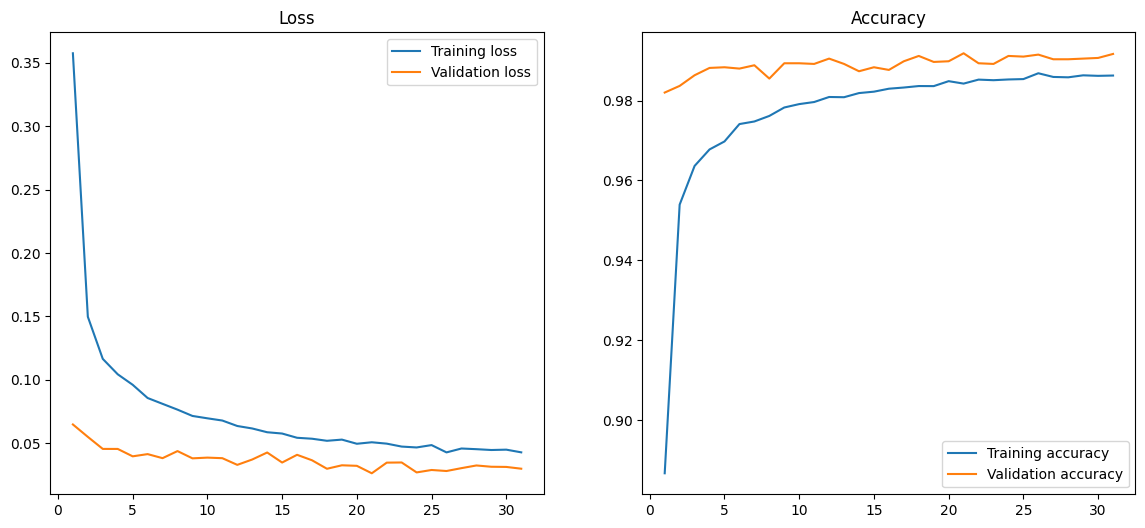

In [17]:
mnist_cnn_2 = Network([
    Conv2d(1, 16, 3, padding=1),  # 16 x 28 x 28
    LeakyReLU(0.1), 
    MaxPool2d(),                  # 16 x 14 x 14

    Conv2d(16, 32, 3, padding=1), # 32 x 14 x 14
    LeakyReLU(0.1), 
    MaxPool2d(),                  # 32 x 7 x 7

    Flatten(),                    # 32*7*7 -> 1568
    
    Dense(128),
    LeakyReLU(0.1),
    Dropout(0.3),

    Dense(10),
])

mnist_cnn_2.compile(loss, solver)

try:
    mnist_cnn_2 = joblib.load('models//mnist_cnn_2.joblib')
except:
    history = mnist_cnn_2.train(dataset=train_data_trans, epochs=50, val_dataset=val_data, early_stopping=early_stopping)
    # save the model
    joblib.dump(mnist_cnn_2, 'models//mnist_cnn_2.joblib')

plot_hist(mnist_cnn_2.history)

In [18]:
mnist_cnn_2.early_stopped

{'epoch_stopped': 31, 'epoch_params': 21}

In [19]:
y_pred = mnist_cnn_2.predict(X_test)
accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

0.9936

              precision    recall  f1-score   support

           0     0.9939    0.9990    0.9964       980
           1     0.9965    0.9974    0.9969      1135
           2     0.9951    0.9922    0.9937      1032
           3     0.9931    0.9970    0.9951      1010
           4     0.9919    0.9939    0.9929       982
           5     0.9877    0.9922    0.9899       892
           6     0.9968    0.9875    0.9921       958
           7     0.9903    0.9961    0.9932      1028
           8     0.9969    0.9897    0.9933       974
           9     0.9930    0.9901    0.9916      1009

    accuracy                         0.9936     10000
   macro avg     0.9935    0.9935    0.9935     10000
weighted avg     0.9936    0.9936    0.9936     10000



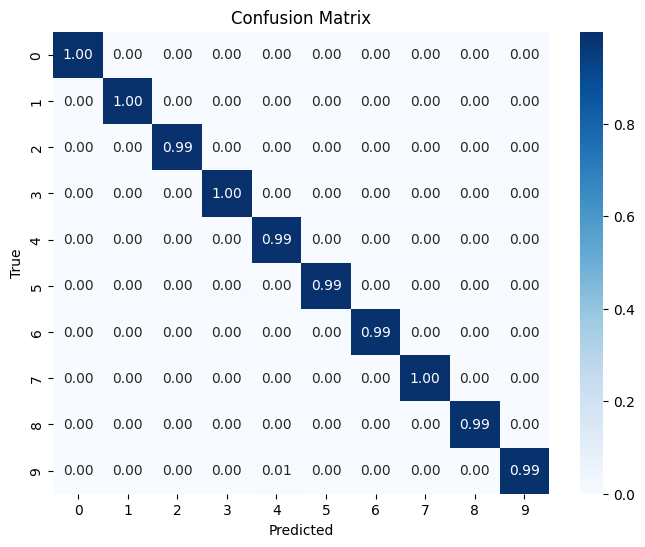

In [20]:
evaluate_classification(y_test, y_pred)